# LSTM (Binary) for shifted MIT data
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling  
rescaling: MinMax

If you don't have the original files: run the notebook `preprocessing_mit_binary_shift_minmax_oversampling.ipynb`     

Input file:(The preprocessed data)

mitbih_binary_train_shift_minmax_oversampling.csv
mitbih_binary_test_shift_minmax_oversampling.csv

Output: lstm model trained  
model_mit_binary_shift_lstm.h5  


| **Feature**                     | **LSTM**                                                      | **GRU**                                                 |
|---------------------------------|---------------------------------------------------------------|---------------------------------------------------------|
| **Types of Gates**              | 3 gates: Input, Forget, Output                                | 2 gates: Update, Reset                                  |
| **Memory Structure**            | Keeps two kinds of memory: cell and hidden                    | Only one memory type: hidden                            |
| **Computational Demand**        | Uses more power and memory                                    | Uses less power and memory                              |
| **Training Speed**              | Takes more time to train                                      | Trains faster                                           |
| **Best for Long Sequences**     | Great for remembering long sequences and details              | Good for simpler, shorter sequences                     |
| **When to Use**                 | When you need to remember a lot of details over a long period | When you want quicker training with fewer details       |


In [3]:
import sys
import os

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q
    !pip install tensorflow
    !pip install seaborn

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive.
    data_path = '/content/drive/MyDrive/heartbeat-deep-model/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read data


In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax


RawFiles = dict({
    'train': data_path + 'mitbih_binary_train_shift_minmax_oversampling.csv',
    'test': data_path + 'mitbih_binary_test_shift_minmax_oversampling.csv'
})

OutputFiles = dict({
    'model': model_output_path +  'model_mit_binary_shift_lstm'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)


# LSTM with MinMax Scaler and Oversampling

In [5]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train.shape)  # samples, timesteps, features
print("X_test shape:", X_test.shape)    # samples, timesteps, features


X_train shape: (144942, 187, 1)
X_test shape: (20284, 187, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(187, activation='tanh', return_sequences=True))

# Hidden layers
model.add(LSTM(16, activation='tanh'))
model.add(Dropout(0.3))

# Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Choose an optimizer with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)

# Lists to store metrics over epochs
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size and number of epochs
batch_size = 32
epochs = 100

# Training loop on the full dataset
for epoch in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size,
                        validation_data=(X_test, y_test), verbose=0,
                        callbacks=[early_stopping, lr_scheduler])

    # Append metrics to respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Predictions and optimal threshold calculation on the test set
y_pred_test = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Convert probabilities to binary predictions based on optimal threshold
y_pred_class_test = (y_pred_test >= optimal_threshold).astype(int)

# Model Evaluation on the test set
print("Evaluation on Test Set")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class_test))
print(f"F1 Score: {f1_score(y_test, y_pred_class_test):.4f}")

# Predictions on the full training set (X_train) using the optimal threshold
y_pred_full_train = model.predict(X_train)
y_pred_class_full_train = (y_pred_full_train >= optimal_threshold).astype(int)

# Model Evaluation on the full training set
print("\nEvaluation on Full Training Set")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_class_full_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_class_full_train))
print(f"F1 Score: {f1_score(y_train, y_pred_class_full_train):.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 187, 187)            │         141,372 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │          13,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,445 (603.30 KB)

 Trainable params: 154,445 (603.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10/100 - Loss: 0.2310, Val Loss: 0.2509, Accuracy: 0.9197, Val Accuracy: 0.9063
Epoch 20/100 - Loss: 0.1715, Val Loss: 0.2142, Accuracy: 0.9387, Val Accuracy: 0.9280
Epoch 30/100 - Loss: 0.1899, Val Loss: 0.1466, Accuracy: 0.9337, Val Accuracy: 0.9535
Epoch 40/100 - Loss: 0.1689, Val Loss: 0.1294, Accuracy: 0.9411, Val Accuracy: 0.9528
Epoch 50/100 - Loss: 0.1799, Val Loss: 0.2284, Accuracy: 0.9361, Val Accuracy: 0.9073
Epoch 60/100 - Loss: 0.1810, Val Loss: 0.2085, Accuracy: 0.9381, Val Accuracy: 0.9334
Epoch 70/100 - Loss: 0.1580, Val Loss: 0.1921, Accuracy: 0.9463, Val Accuracy: 0.9332
Epoch 80/100 - Loss: 0.1329, Val Loss: 0.1372, Accuracy: 0.9562, Val Accuracy: 0.9528
Epoch 90/100 - Loss: 0.1264, Val Loss: 0.1299, Accuracy: 0.9588, Val Accuracy: 0.9570
Epoch 100/100 - Loss: 0.1344, Val Loss: 0.1538, Accuracy: 0.9556, Val Accuracy: 0.9484
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Optimal Threshold: 0.45
Evaluation on Test Set
Confusion Matrix:
 [[17088  1030]
 [  104  2062]]



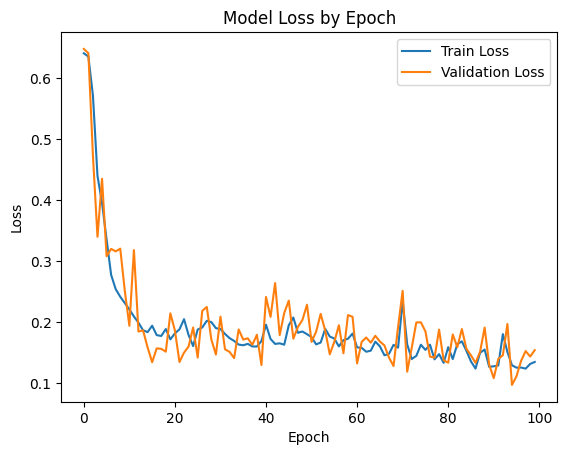

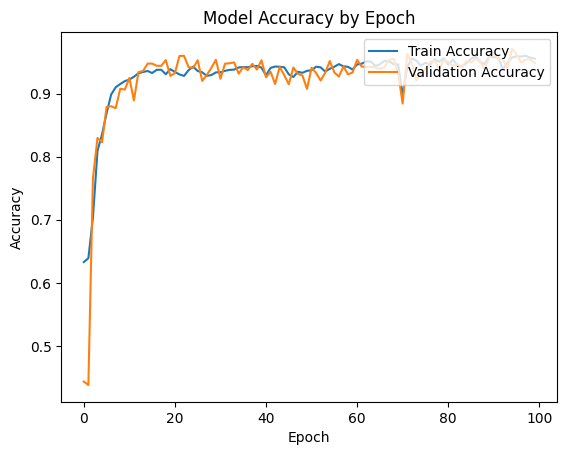

634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Confusion Matrix:
 [[17194   924]
 [  122  2044]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     18118
         1.0       0.69      0.94      0.80      2166

    accuracy                           0.95     20284
   macro avg       0.84      0.95      0.88     20284
weighted avg       0.96      0.95      0.95     20284

F1 Score: 0.7963


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions using the best model (with best weights)
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)  # Using 0.5 as the threshold for binary classification

# Evaluating the best-performing model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")

### Save model

In [8]:
# Save the model with TensorFlow format
model_path = OutputFiles.get('model') + '.h5'  # Append .h5 extension
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/heartbeat-deep-model/model_mit_binary_shift_lstm.h5


In [9]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-12 21:51:29.044793
